## GAN
Generative Adversarial Network

In [33]:
import random
import numpy as np
import scipy.stats as stats

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

### Real (R) world data

The original, genuine data set which G tried to mimic.

In our case, we’ll start with the simplest possible R — a bell curve. This function takes a mean and a standard deviation and returns a function which provides the right shape of sample data from a Gaussian with those parameters.

In [2]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))

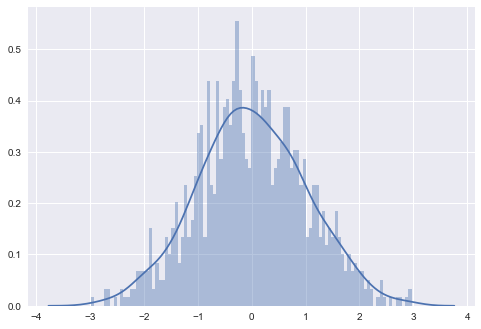

In [4]:
data = get_distribution_sampler(0, 1)(1000).numpy()
sns.distplot(data, bins=100)

### Input (I) to generator
This is the random noise that goes into the generator as a source of entropy.

The input into the generator is also random, but to make our job a little bit harder, let’s use a uniform distribution rather than a normal one. This means that our model G can’t simply shift/scale the input to copy R, but has to reshape the data in a non-linear way.

In [5]:
def get_generator_input_sampler():
    return lambda n, m: torch.rand(n, m)

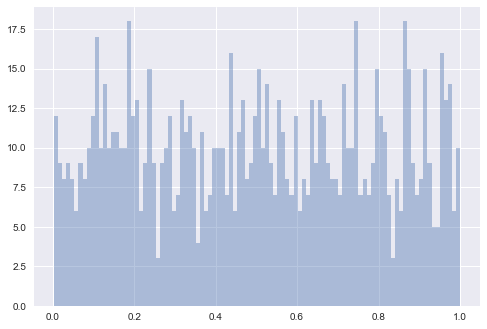

In [6]:
data = get_generator_input_sampler()(1, 1000).numpy()
sns.distplot(data, bins=100, kde=False)

### Generator

The generator is a standard feedforward graph — two hidden layers, three linear maps. We’re using an ELU (exponential linear unit). G is going to get the uniformly distributed data samples from I and somehow mimic the normally distributed samples from R.

In [7]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

### Discriminator

The discriminator code is very similar to G’s generator code; a feedforward graph with two hidden layers and three linear maps. It’s going to get samples from either R or G and will output a single scalar between 0 and 1, interpreted as ‘fake’ vs. ‘real’. This is about as milquetoast as a neural net can get.

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

### Hyperparams

In [9]:
# Data params
data_mean = 4
data_stddev = 1.25

In [10]:
# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

In [11]:
d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 30000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

### Loss and Optim

In [25]:
G = Generator(g_input_size, g_hidden_size, g_output_size)
G

Generator (
  (fc1): Linear (1 -> 50)
  (fc2): Linear (50 -> 50)
  (fc3): Linear (50 -> 1)
)

In [26]:
D = Discriminator(d_input_size, d_hidden_size, d_output_size)
D

Discriminator (
  (fc1): Linear (100 -> 50)
  (fc2): Linear (50 -> 50)
  (fc3): Linear (50 -> 1)
)

In [27]:
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [28]:
dsampler = get_distribution_sampler(data_mean, data_stddev)
gsampler = get_generator_input_sampler()

### Helper fn

In [36]:
def v2n(*arg):
    return np.array([item.data.numpy() for item in arg])

In [46]:
def normtest(dist):
    return stats.normaltest(v2n(dist)[0][0])[1]

### Fight

In [50]:
for epochs in range(num_epochs):
    for _ in range(d_steps):
        D.zero_grad()
        
        # 1. train D on real data
        d_real_input = Variable(dsampler(d_input_size))
        d_real_output = D(d_real_input)
        d_target = Variable(torch.ones(1))
        d_loss = criterion(d_real_output, d_target)
        d_loss.backward()
        
        # 2. train D on fake data from G
        g_input = Variable(gsampler(minibatch_size, g_input_size))
        d_fake_input = G(g_input).detach().t()
        d_fake_output = D(d_fake_input)
        d_target = Variable(torch.zeros(1))
        d_loss = criterion(d_fake_output, d_target)
        d_loss.backward()
        
        d_optimizer.step()
    
    for _ in range(g_steps):
        G.zero_grad()
        
        # produce fake data using I
        g_input = Variable(gsampler(minibatch_size, g_input_size))
        g_output = G(g_input).t()
        
        # check the fake data by D
        d_output = D(g_output)
        d_target = Variable(torch.ones(1))
        
        # magic
        # minimize the loss such that,
        # fake data is acceptable
        g_loss = criterion(d_output, d_target)
        g_loss.backward()
        
        g_optimizer.step()
    
    if epochs % 1000 == 0:
        print(normtest(d_real_input), normtest(d_fake_input))

0.568791814614 3.19442653188e-05
0.714658317033 0.000404899474868
0.46026547234 3.07481152277e-05
0.562712577195 7.98614949577e-09
0.330756997499 3.02577857593e-08
0.0266002191899 0.00171764952129
0.108421872319 5.38190864492e-07
0.416044717315 1.16960208596e-06
0.607593459448 1.12182814682e-08
0.148402046243 3.0228017704e-07
0.559325423454 1.62248552691e-11
0.609473868365 0.000927776935823
0.354984017707 0.000496069721954
0.452880618898 2.13854626909e-19
0.950766182159 6.44136453604e-10
0.166459890917 2.90354876879e-05
0.812752426848 0.00247999067731
0.889779648767 0.000120883652982
0.728248109002 3.42082421264e-06
0.852086245651 0.000568495655723
0.254479159109 0.000107486974703
0.370276752361 7.39194287427e-13
0.803150255767 1.16569753693e-08
0.405254709751 5.19197188211e-08
0.585460338047 0.00233537095457
0.0710607858902 4.43328105444e-18
0.396996218471 2.68996164344e-14
0.217132751555 6.54913285731e-08
0.658981704261 4.15961525074e-09
0.790624212127 2.08663379536e-10


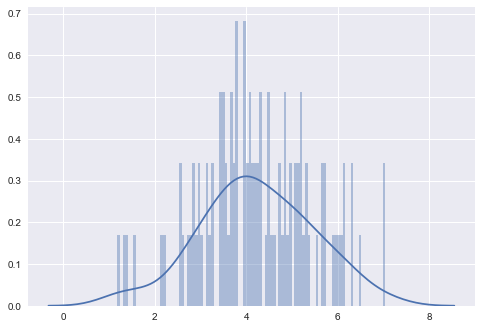

In [51]:
sns.distplot(d_real_input.data.numpy(), bins=100)

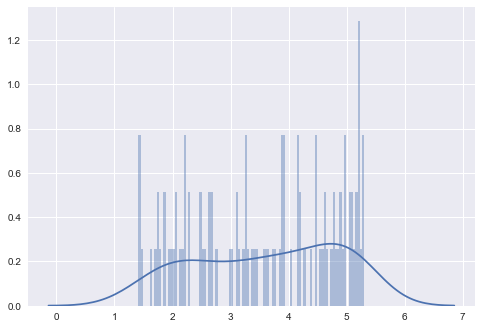

In [52]:
sns.distplot(d_fake_input.data.numpy(), bins=100)